In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model,  pipeline, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from heapq import nlargest
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import PolynomialFeatures, scale
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# 1.0: Load Data 

In [2]:
data = pd.read_excel("AmesHousing.xls")
target = data['SalePrice']
data= data.drop(['SalePrice'], axis=1)
df = data.select_dtypes(exclude=['object'])
categorical = data.select_dtypes(exclude=['int64','float64'])
categorical_name = list(categorical)
numeric_features = list(df)


# 1.1: Visualize the Univariate Distribution of Each Continuous, and the Distribution of the Target

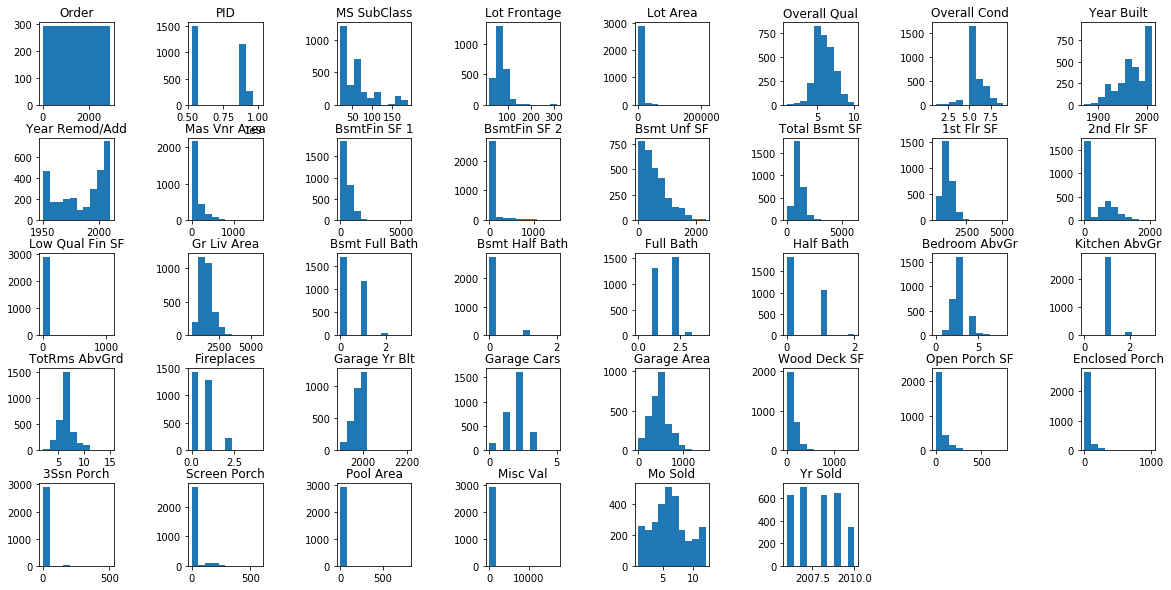

In [3]:
# Create histogram for each univariate distribution
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=1)
for i in range(len(df.columns)):
    ax = fig.add_subplot(5, 8, i+1)
    ax.hist(df.iloc[:,i])
    ax.set_title(list(df)[i])


Text(0.5, 0, 'SalePrice')

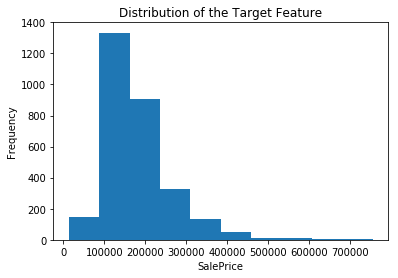

In [4]:
#Visualize the target feature
plt.hist(target)
plt.title("Distribution of the Target Feature")
plt.ylabel("Frequency")
plt.xlabel("SalePrice")

# Notice & Treatment for 1.1

There are some continuous features following the Gaussian distribution. However, most variables are heavily skewed. Also, "Other" seems to follow the uniform distribution. For those skewed distributions, it would be better to take a log transformation to make them more normal distribution shape.

# 1.2: Visualize the Dependency between the Target Feature and Each Continuous Variables

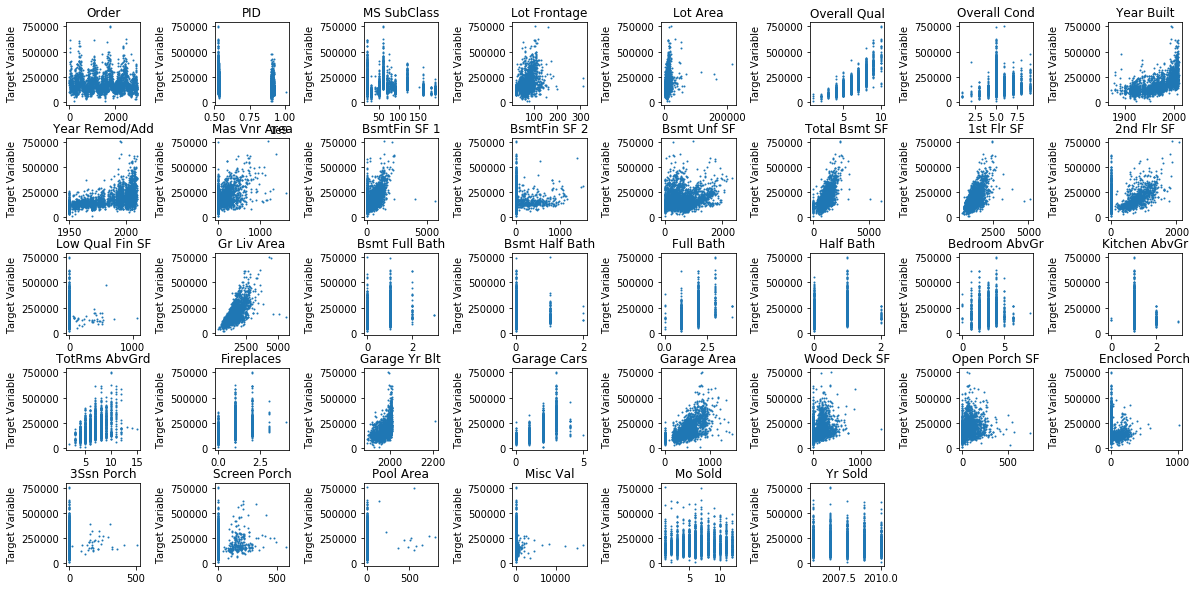

In [5]:
# Create subplots and plot scatter plots on each continuous features with respect to the target feature
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=1)
for i in range(len(df.columns)):
    ax = fig.add_subplot(5, 8, i+1)
    ax.scatter(df.iloc[:,i],target,s=1)
    ax.set_title(list(df)[i])
    ax.set_ylabel("Target Variable")

# 1.3: Split Data & Cross Validate the models & Visualize the Relationships among the Top Three R Squared Features 

In [6]:
# Look for the top three R^2 features
R_2_dic = {}
for i in range(len(categorical_name)):
    dummy_categorical = pd.get_dummies(categorical.iloc[:,i-1])
    
    X_train, X_test, y_train, y_test = train_test_split(dummy_categorical, target, test_size=0.3)

    scaler = StandardScaler()
    md = scaler.fit(X_train)
    X_train_scaled = md.transform(X_train)


    lm = linear_model.LinearRegression()
    model = lm.fit(X_train_scaled,y_train)
    scores = cross_val_score(model,dummy_categorical,target, cv=3, scoring='r2')
    avg_scores = sum(scores) / float(len(scores))
    R_2_dic.update({categorical_name[i]:avg_scores})
    
    


sorted_dic = sorted(R_2_dic.items(), key=lambda v: v[1], reverse=True)
print(sorted_dic[0:3])




[('Bsmt Cond', 0.5088519401667361), ('Exter Cond', 0.4977580547800917), ('Functional', 0.4757821384125214)]


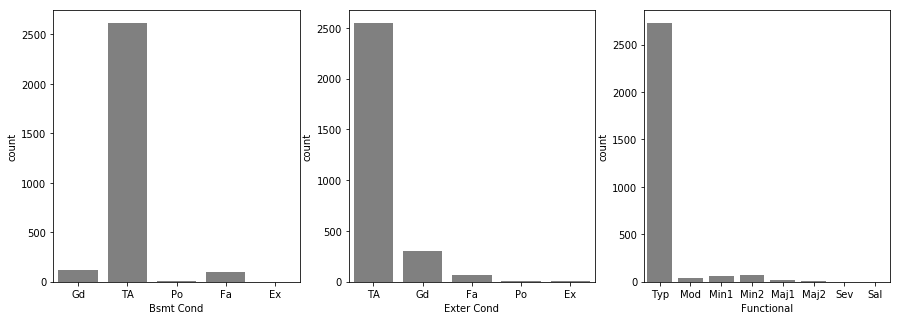

In [7]:
# Store the top three R^2 features into another dataframe
cat = categorical[['Bsmt Cond','Exter Cond','Functional']]

# Plot histgram correspoinding to those features
f, axes = plt.subplots(1, 3,figsize=(15,5))
sns.countplot(cat['Bsmt Cond'], color='grey', ax=axes[0])
sns.countplot(cat['Exter Cond'], color='grey', ax=axes[1])
sns.countplot(cat['Functional'], color='grey', ax=axes[2])

# 1.4: Evaluation on the Models 

In [8]:
# Create a categorical transformer 
categorical_features = categorical_name
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Take a column transfomer 
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Create pipelines for each model
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('ols', linear_model.LinearRegression())])

ridge = Pipeline(steps=[('preprocessor', preprocessor),
                      ('ridge', Ridge())])

lasso = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lasso', linear_model.Lasso(tol=1))])

elastic = Pipeline(steps=[('preprocessor', preprocessor),
                      ('elastic', ElasticNet())])


In [9]:
#Split data into the training set and test set 
X_train, X_test, y_train, y_test = train_test_split(categorical, target, test_size=0.3,shuffle=False)

#Fit each model
reg.fit(X_train,y_train)
scores = cross_val_score(reg,X_train, y_train, cv=3)
scores = sum(scores) / float(len(scores))
print("Regression:")
print(scores)
print("")

ridge.fit(X_train,y_train)
scores = cross_val_score(ridge,X_train, y_train, cv=3)
scores = sum(scores) / float(len(scores))
print("Ridge:")
print(scores)
print("")

lasso.fit(X_train,y_train)
scores = cross_val_score(lasso,X_train, y_train, cv=3)
scores = sum(scores) / float(len(scores))
print("Lasso:")
print(scores)
print("")

elastic.fit(X_train,y_train)
scores = cross_val_score(elastic,X_train, y_train, cv=3)
scores = sum(scores) / float(len(scores))
print("ElasticNet:")
print(scores)



Regression:
0.788688062216835

Ridge:
0.8075366230619507

Lasso:
0.7037713902695856

ElasticNet:
0.65004956062464


In [10]:
# Create pipelines to transform categorical and continuous features
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value = 'missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer, numeric_features),
        ('cat', categorical_transformer,categorical_features)])


# Instantiate classifiers for each model
clf1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())])

clf2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', linear_model.Lasso(tol=1))])

clf3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('elastic', ElasticNet())])



In [11]:
#Split data into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

#Fit each model and evaluate cross validation scores
clf1.fit(X_train,y_train)
scores = cross_val_score(clf1,X_train,y_train, cv=3)
scores = sum(scores) / float(len(scores))
print("Ridge After Tuning the Parameter:")
print(scores)
print("")

clf2.fit(X_train,y_train)
scores = cross_val_score(clf2,X_train,y_train, cv=3)
scores = sum(scores) / float(len(scores))
print("Lasso After Tuning the Parameter:")
print(scores)
print("")

clf3.fit(X_train,y_train)
scores = cross_val_score(clf3,X_train,y_train, cv=3)
scores = sum(scores) / float(len(scores))
print("Elastic After Tuning the Parameter:")
print(scores)

Ridge After Tuning the Parameter:
0.8784526910292412

Lasso After Tuning the Parameter:
0.7684014950067057

Elastic After Tuning the Parameter:
0.8459978082350457


# Conclusion for 1.4:

Yes, scaling helps the model significantly improve the result.

# 1.5: Tune the Parameter by the GridSearchCV

In [12]:
# Split dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

# Seach for the best parameter by GridSearchCV for Ridge Regression
param_grid = {'ridge__alpha': [0.01,0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(clf1, param_grid=param_grid, cv=5)
ridge_grid.fit(X_train, y_train)


print("best mean cross-validation score of Ridge: {:.3f}".format(ridge_grid.best_score_))
print("best parameters of Ridge: {}".format(ridge_grid.best_params_))
print("test-set score of Ridge: {:.3f}".format(ridge_grid.score(X_test, y_test)))
print("")


# Seach for the best parameter by GridSearchCV for Lasso Regression
param_grid = {'lasso__alpha': np.logspace(-3, 0, 13)}

lasso_grid = GridSearchCV(clf2, param_grid=param_grid, cv=5)
lasso_grid.fit(X_train, y_train)

print("best mean cross-validation score of Lasso: {:.3f}".format(lasso_grid.best_score_))
print("best parameters of Lasso: {} ".format(lasso_grid.best_params_))
print("test-set score of Lasso: {:.3f}".format(lasso_grid.score(X_test, y_test)))
print("")


# Seach for the best parameter by GridSearchCV for ElastcNet
param_grid = {'elastic__alpha': [0.01,0.1, 1, 10, 100]}

elastic_grid = GridSearchCV(clf3, param_grid=param_grid, cv=5)
elastic_grid.fit(X_train, y_train)

print("best mean cross-validation score of Elastic: {:.3f}".format(elastic_grid.best_score_))
print("best parameters of Elastic: {}".format(elastic_grid.best_params_))
print("test-set score of Elastic: {:.3f}".format(elastic_grid.score(X_test, y_test)))



best mean cross-validation score of Ridge: 0.807
best parameters of Ridge: {'ridge__alpha': 100}
test-set score of Ridge: 0.912

best mean cross-validation score of Lasso: 0.708
best parameters of Lasso: {'lasso__alpha': 1.0} 
test-set score of Lasso: 0.813



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best mean cross-validation score of Elastic: 0.807
best parameters of Elastic: {'elastic__alpha': 0.1}
test-set score of Elastic: 0.912


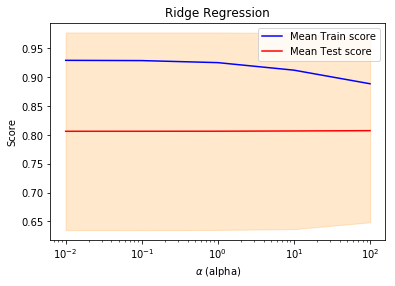

In [13]:
# Visualize the dependence of the validation score for Ridge Regression
ridge_alphas = [0.01,0.1, 1, 10, 100]

train_scores_mean = ridge_grid.cv_results_["mean_train_score"]
train_scores_std = ridge_grid.cv_results_["std_train_score"]
test_scores_mean = ridge_grid.cv_results_["mean_test_score"]
test_scores_std = ridge_grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Ridge Regression')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')

plt.semilogx(ridge_alphas, train_scores_mean, label='Mean Train score',
             color='blue')

plt.semilogx(ridge_alphas, test_scores_mean,
             label='Mean Test score', color='red')


plt.gca().fill_between(ridge_alphas,
                       test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.legend(loc='best')

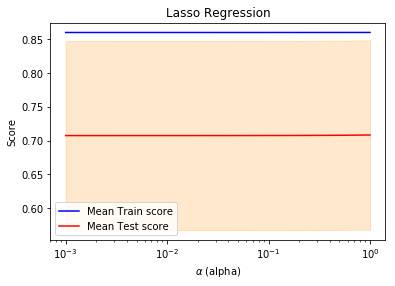

In [15]:
# Visualize the dependence of the validation score for Lasso Regression
lasso_alphas = np.logspace(-3, 0, 13)

train_scores_mean = lasso_grid.cv_results_["mean_train_score"]
train_scores_std = lasso_grid.cv_results_["std_train_score"]
test_scores_mean = lasso_grid.cv_results_["mean_test_score"]
test_scores_std = lasso_grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Lasso Regression')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')

plt.semilogx(lasso_alphas, train_scores_mean, label='Mean Train score',
             color='blue')
plt.semilogx(lasso_alphas, test_scores_mean,
             label='Mean Test score', color='red')


plt.gca().fill_between(lasso_alphas,
                       test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.legend(loc='best')

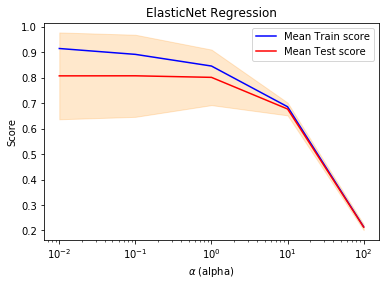

In [16]:
# Visualize the dependence of the validation score for ElasticNet
elastic_alphas = [0.01,0.1, 1, 10, 100]

train_scores_mean = elastic_grid.cv_results_["mean_train_score"]
train_scores_std = elastic_grid.cv_results_["std_train_score"]
test_scores_mean = elastic_grid.cv_results_["mean_test_score"]
test_scores_std = elastic_grid.cv_results_["std_test_score"]

plt.figure()
plt.title('ElasticNet Regression')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')
# plot train scores
plt.semilogx(elastic_alphas, train_scores_mean, label='Mean Train score',
             color='blue')
plt.semilogx(elastic_alphas, test_scores_mean,
             label='Mean Test score', color='red')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(elastic_alphas,
                       test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.legend(loc='best')

# Conclusion for 1.5:

Yes, tuning the parameter increases the results for all models.

# 1.6: Visualize the Coefficients

In [17]:
# Length of Ridge coefficients
len(ridge_grid.best_estimator_.steps[1][1].coef_)

318

Text(0.5, 1.0, 'Ridge Coefficients')

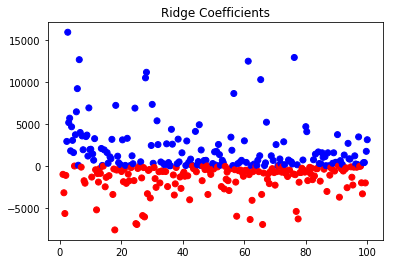

In [18]:
# Visualize the coefficients of Ridge Regression
ridge_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=0.01))])

ridge = ridge_clf.fit(X_train,y_train)

plt.scatter(np.linspace(1,100,318),ridge_grid.best_estimator_.steps[1][1].coef_,c=np.sign(ridge_grid.best_estimator_.steps[1][1].coef_), cmap="bwr_r")
plt.title('Ridge Coefficients')
#

In [19]:
# Take argsort on the list containing all coefficients
np.argsort(np.absolute(ridge_grid.best_estimator_.steps[1][1].coef_))

array([112, 277, 196, 274, 111, 150, 287, 177,  70, 210, 224, 128,  12,
        80, 135,  41, 225,  42,  65, 202, 146, 310, 143,  16, 164, 200,
       309, 169, 201, 134, 159, 229, 106, 244, 140,  60, 300, 231, 307,
       161,  79,  19, 291, 303, 306, 257, 199, 269, 279, 118,  95, 305,
       239,  84,  71, 182, 105,  73, 295, 227, 119, 156, 267, 259,  94,
       281,  47, 249, 155,  59,  78, 280, 136, 218, 265, 211,  38, 264,
       313,  58,  64, 174, 137, 290, 167, 110,  53, 157, 294, 314, 184,
       285, 191, 131, 272, 284,  90, 238, 102, 148, 121, 152, 179,  81,
        34, 237, 141, 236, 185,  56, 192, 190, 251,  89, 183, 153, 103,
       289, 233, 147, 292, 283, 219, 186, 166, 149, 203,  32, 104,  61,
       107, 235, 250, 256, 223, 198, 216, 204, 100, 139, 261, 171, 252,
       126, 228, 299, 133, 248, 247, 226, 220, 298,  50, 209, 187, 232,
        39,  36, 214, 258, 240,  68, 271, 125,   0, 154, 194, 242,  49,
       273, 115, 278,  57,   3,  26,  48, 304,  72, 217, 130, 20

In [96]:
# Top three important categorical features 
print("The first important featrue for Ridge Regression is: " + preprocessor.transformers_[1][1].named_steps.onehot.get_feature_names(categorical_features)[112])
print("The second important featrue for Ridge Regression is: " + preprocessor.transformers_[1][1].named_steps.onehot.get_feature_names(categorical_features)[277])
print("The third important featrue for Ridge Regression is: " + preprocessor.transformers_[1][1].named_steps.onehot.get_feature_names(categorical_features)[196])

The first important featrue for Ridge Regression is: Bsmt Cond_Po
The second important featrue for Ridge Regression is: Land Contour_Lvl
The third important featrue for Ridge Regression is: Garage Type_Basment
The forth important featrue for Ridge Regression is: Condition 2_PosA
The fifth important featrue for Ridge Regression is: Bsmt Qual_missing


In [20]:
# Length of Ridge coefficients
len(lasso_grid.best_estimator_.steps[1][1].coef_)

318

Text(0.5, 1.0, 'Lasso Coefficients')

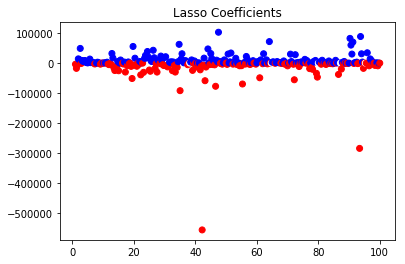

In [28]:
# Visualize the coefficients of Lasso Regression
lasso_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', linear_model.Lasso(alpha=1.0,tol=1))])

lasso = lasso_clf.fit(X_train,y_train)

plt.scatter(np.linspace(1,100,318),lasso_grid.best_estimator_.steps[1][1].coef_,c=np.sign(lasso_grid.best_estimator_.steps[1][1].coef_), cmap="bwr_r")
plt.title('Lasso Coefficients')

In [29]:
# Take argsort on the list containing all coefficients
np.argsort(np.absolute(lasso_grid.best_estimator_.steps[1][1].coef_))

array([253, 204, 276, 119, 302, 236,  46, 301,  27,  57, 282,  30, 275,
        49, 285, 186, 216, 281, 317, 272, 270, 116, 181, 157, 240, 203,
        53,  70, 267, 295, 316, 197,  24, 223, 245, 311, 152, 166, 303,
       160,  22, 283, 175, 222,  25, 226, 214,  48, 170, 305, 189,  65,
       215, 313, 129, 234, 269, 230,  29,  28, 198,  31, 265, 169, 208,
       118,  13, 113, 212, 125, 284, 151, 314, 128,  69, 259, 139,  32,
       127, 262,  12, 123, 154, 184,  19, 220, 263, 290,  36,   6, 291,
        88,  16, 209, 266,  99, 294, 163, 273, 292, 187, 213, 183, 260,
       176,  21,  84, 165, 243,  56, 195, 255, 180, 268, 232,  18,  11,
       238, 201,  17, 207, 278, 219, 237, 309, 200,  14, 279, 242, 205,
        20, 254, 211,  23,  33,  34,  50, 231, 249, 293, 177,  98, 164,
       218, 299, 120,  51, 188,  26, 153, 310, 102,   0, 256,  55, 227,
       235, 258, 105, 161,  37, 148, 206, 158, 100,  66, 168, 261, 182,
       107, 143, 140, 248, 191, 210, 190,  91, 225,  35,  97,  4

In [32]:
# Top three important categorical features 
print("The first important featrue for Lasso Regression is: " + preprocessor.transformers_[1][1].named_steps.onehot.get_feature_names(categorical_features)[253])
print("The first important featrue for Lasso Regression is: " + preprocessor.transformers_[1][1].named_steps.onehot.get_feature_names(categorical_features)[204])
print("The first important featrue for Lasso Regression is: " + preprocessor.transformers_[1][1].named_steps.onehot.get_feature_names(categorical_features)[276])


The first important featrue for Lasso Regression is: Fence_GdPrv
The first important featrue for Lasso Regression is: Kitchen Qual_Fa
The first important featrue for Lasso Regression is: Sale Condition_Alloca


In [23]:
# Take argsort on the list containing all coefficients
len(elastic_grid.best_estimator_.steps[1][1].coef_)

318

Text(0.5, 1.0, 'ElasticNet Coefficients')

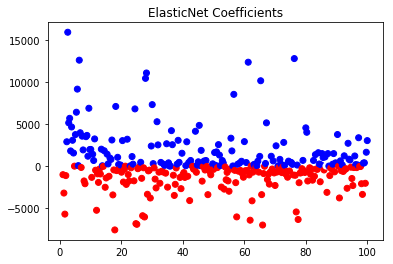

In [26]:
#Visualize the coefficients of ElasticNet
elastic_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('elastic', ElasticNet(alpha=0.1))])

elastic = elastic_clf.fit(X_train,y_train)

plt.scatter(np.linspace(1,100,318),elastic_grid.best_estimator_.steps[1][1].coef_,c=np.sign(elastic_grid.best_estimator_.steps[1][1].coef_), cmap="bwr_r")
plt.title('ElasticNet Coefficients')

In [27]:
np.argsort(np.absolute(elastic_grid.best_estimator_.steps[1][1].coef_))

array([274, 277, 196, 112, 111,  12,  65, 177, 210, 200, 224,  70, 287,
        80, 135,  41, 128, 150,  42, 309, 143, 202,  16, 310, 146, 164,
       106, 134, 159, 231, 169, 229, 140, 244, 201,  60, 291, 307, 300,
       269,  19, 225, 303, 305, 161, 306,  58, 199, 239, 257,  71,  84,
        95,  79, 182, 105, 279, 281, 118,  73, 119, 227, 267,  47, 156,
        94, 285, 211, 249,  78,  59, 155, 295, 264, 218, 280, 313, 184,
       259, 136,  38, 167, 174, 284,  64, 110, 157, 314, 265, 294, 137,
       238, 131, 191, 102, 121, 237,  81,  53, 272, 148,  90, 152,  34,
       141, 179, 185, 192,  56, 251, 190, 290, 186,  89, 203, 236, 235,
       147, 219, 183, 103, 289, 153, 233, 292, 149, 166,  32, 133, 261,
       250, 283, 104, 256, 223, 198, 204, 216, 100, 299,  61, 139, 171,
       252, 228, 126,  50, 248, 226, 298, 220, 247, 107, 209, 187,  36,
       232,  39,  49, 214, 258, 125,  68, 271,   0, 154,  57, 194, 240,
       273, 115, 242,  72,   3, 278, 205, 217,  26, 304, 262,  4

In [31]:
# Top three important categorical features 
print("The first important featrue for ElasticNet is: " + preprocessor.transformers_[1][1].named_steps.onehot.get_feature_names(categorical_features)[274])
print("The second important featrue for ElasticNet is: " + preprocessor.transformers_[1][1].named_steps.onehot.get_feature_names(categorical_features)[277])
print("The third important featrue for ElasticNet is: " + preprocessor.transformers_[1][1].named_steps.onehot.get_feature_names(categorical_features)[196])


The first important featrue for ElasticNet is: Sale Condition_Abnorml
The second important featrue for ElasticNet is: Sale Condition_Family
The third important featrue for ElasticNet is: Heating QC_TA
